In [3]:
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np
import pandas as pd
import pymc
import seaborn as sns
import scipy, scipy.stats
from scipy.stats import mode
import pylab
from matplotlib import pyplot as plt
from pymc.Matplot import plot as mcplot
sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/kornel.kielczewski/anaconda/envs/pymc1/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
df = pd.read_csv('data/BRCA-filtered.txt.gz', sep = '\t', index_col = 0)

In [5]:
dft = df.transpose()

In [6]:
dft.describe()

Hybridization REF,ZNF114|163071,ZNF205|7755,ZNF267|10308,ZNF273|10793,ZNF282|8427,ZNF320|162967,ZNF468|90333,ZNF485|220992,ZNF525|170958,ZNF643|65243,ZNF695|57116,ZNF707|286075,ZNF714|148206,ZNF789|285989
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000
mean,12.576513,347.575895,398.256743,187.515418,766.155671,554.047879,525.213938,94.063056,356.378570,54.168991,64.737524,306.359949,207.186751,83.554836
std,20.742740,229.445553,162.465444,94.716513,297.252856,226.898840,265.294146,52.517578,189.589890,50.221778,92.532610,201.956632,144.442256,55.042386
min,0.000000,9.898200,66.974900,13.296500,203.954500,27.126700,0.000000,8.248700,16.313300,2.773200,0.000000,19.690000,5.563800,13.478500
25%,2.991875,202.597050,291.780850,126.669375,567.045500,416.147625,354.286325,58.756425,232.752975,31.028025,13.299850,175.862175,113.151375,51.724725
50%,6.079650,290.524800,374.052700,169.914400,713.686650,533.681900,475.463150,83.982100,316.397200,45.689550,31.317150,252.475900,173.293800,71.558200
75%,13.739800,423.733950,472.502525,230.077300,909.611125,659.080350,643.390675,116.818375,436.268800,65.076475,75.633725,374.347625,261.369675,101.026800
max,223.798800,2199.999400,1396.205800,1195.750700,2461.977200,2460.255000,2473.269800,636.937500,1874.049000,1265.807200,1028.171700,1735.496700,1140.401600,804.298100


In [7]:
sample_row = 'ZNF114|163071'
sample_row_2 = 'ZNF205|7755'

In [8]:
# 1 - tumor
# 11 - healthy
healthy = dft.iloc[dft.index.str.contains("-11A-")]
tumor = dft.iloc[dft.index.str.contains("-01A-")]

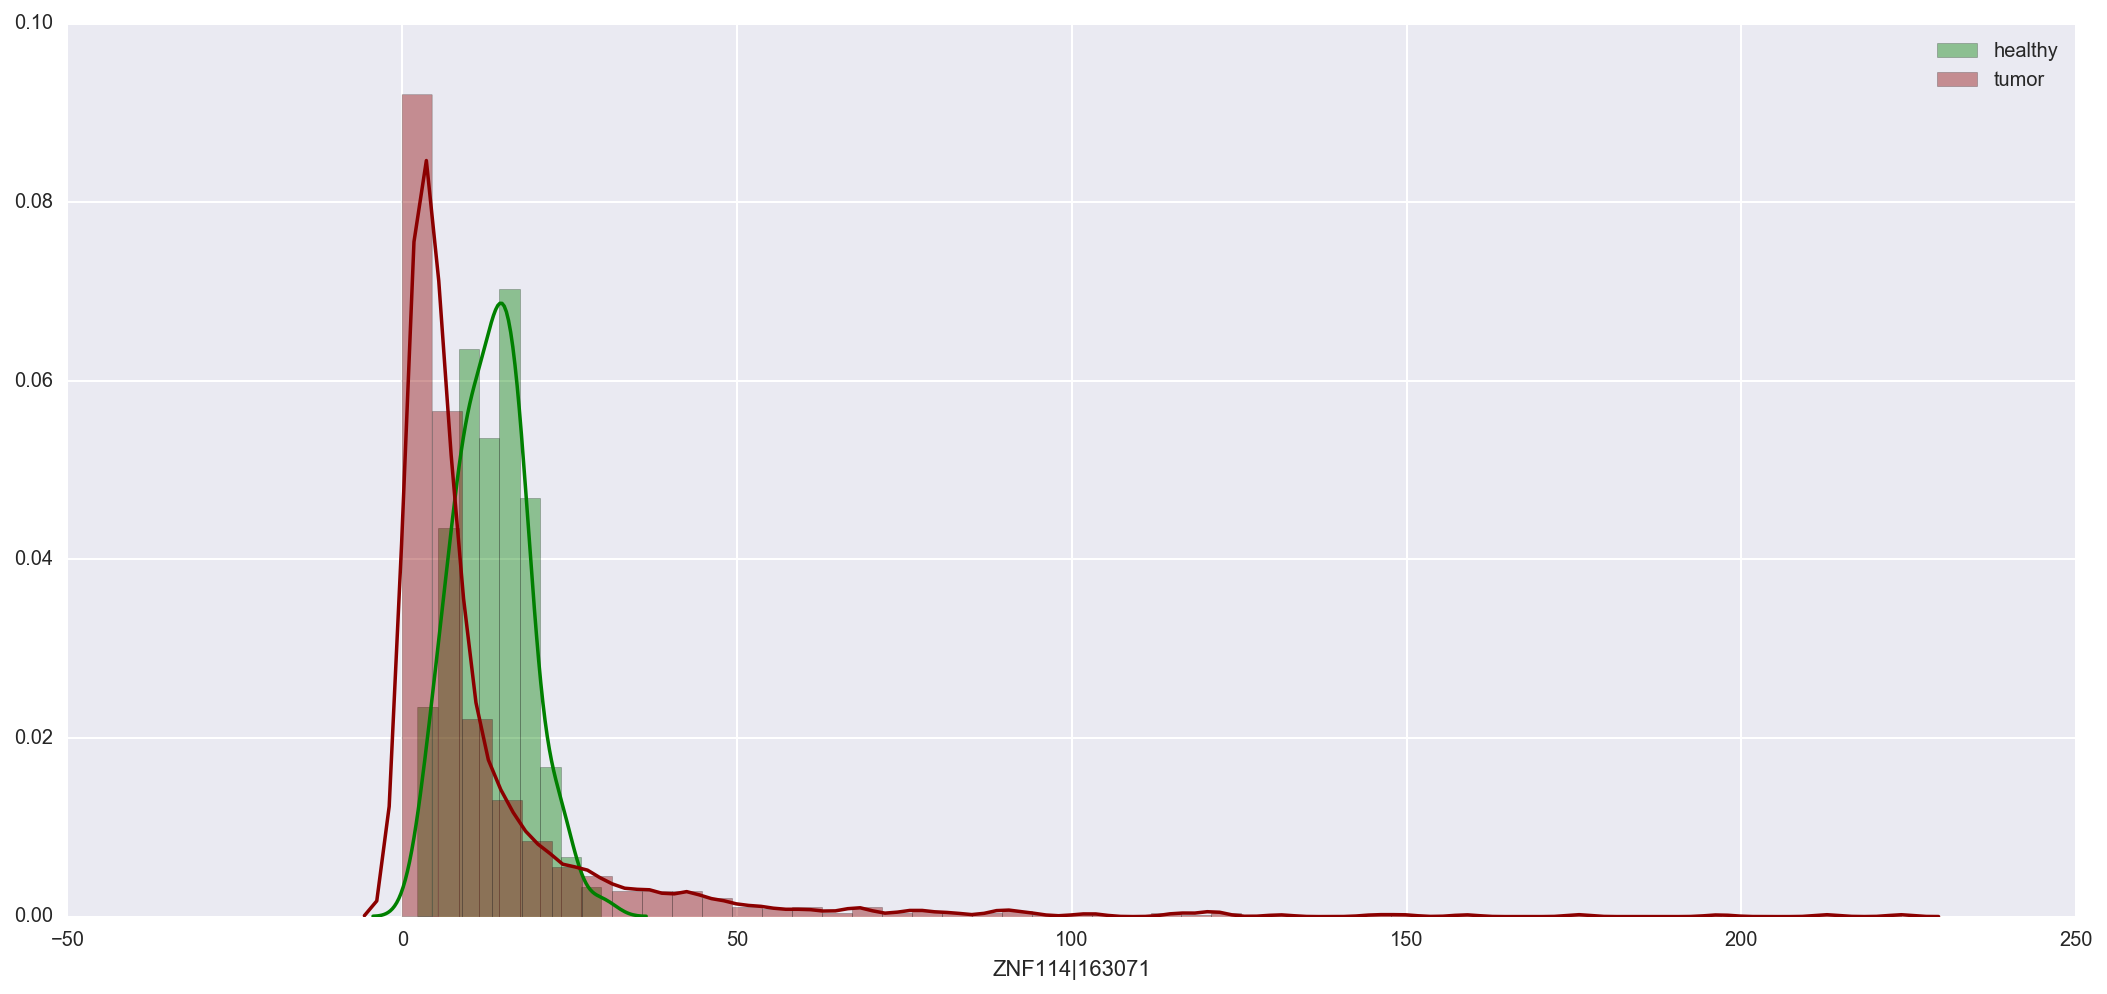

In [9]:
plt.figure(figsize=(18, 8))
sns.distplot(healthy[sample_row], label = 'healthy', color = 'green')
sns.distplot(tumor[sample_row], label = 'tumor', color = 'darkred')
plt.legend()

In [13]:
print 'tumor mode:', mode(tumor[sample_row]).mode[0]
print 'tumor samples:', len(tumor[sample_row])

print 'healthy mode:', mode(healthy[sample_row]).mode[0]
print 'healthy samples:', len(healthy[sample_row])

tumor mode: 0.0
tumor samples: 1080
healthy mode: 2.3211
healthy samples: 98


# Tumor

In [14]:
successes_t = pymc.DiscreteUniform('successes', lower = 1, upper = 20)

p_successes_t = pymc.Uniform('p_success', 0, 1)

@deterministic()
def mu_t(p = p_successes_t, s = successes_t):
    return successes_t / p_successes_t - successes_t

obs_t = pymc.NegativeBinomial('tumor', mu = mu_t, alpha = successes_t, value = tumor[sample_row], observed = True)

In [15]:
model_t = pymc.Model([successes_t, mu_t, obs_t])

map_t = pymc.MAP(model_t)
map_t.fit()

mcmc_t = pymc.MCMC(model_t)
mcmc_t.sample(10000, 5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 11.7 sec

Plotting successes
Plotting p_success


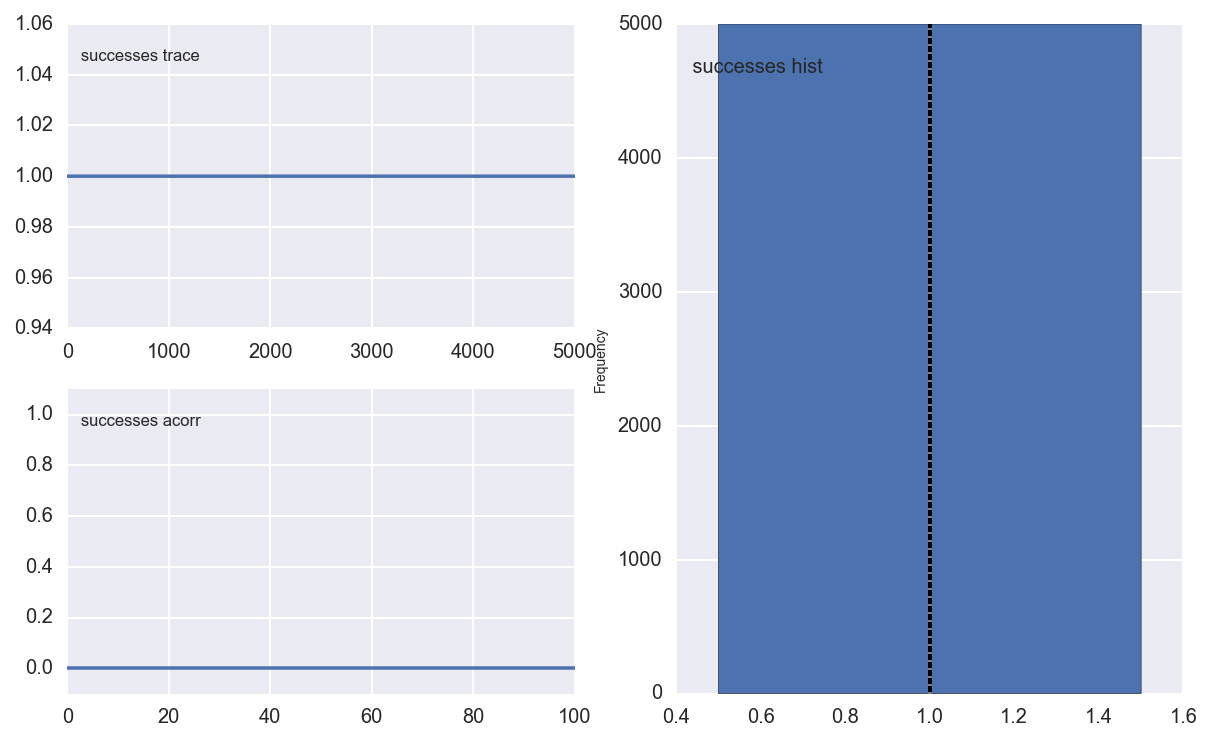

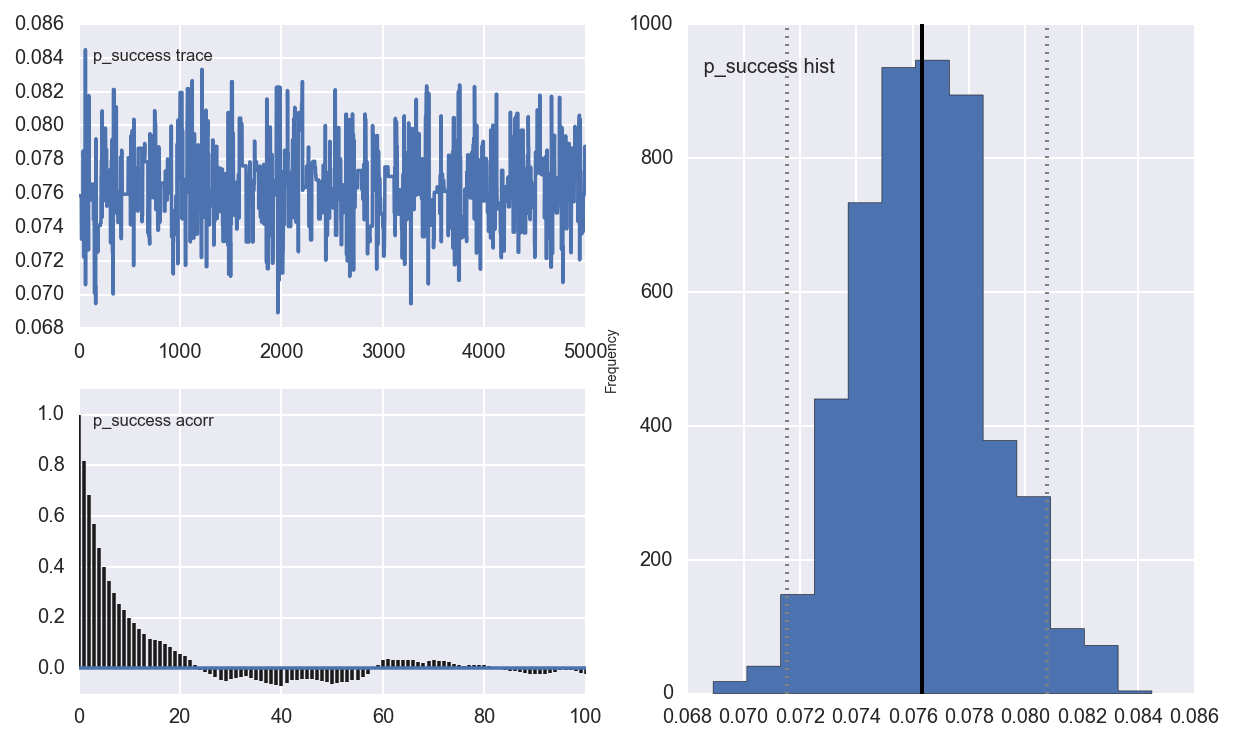

In [18]:
mcplot(mcmc_t.trace('successes'), common_scale=False)
mcplot(mcmc_t.trace('p_success'), common_scale=False)

Successes mean probability: 0.076393322324
Successes mean count: 1.0


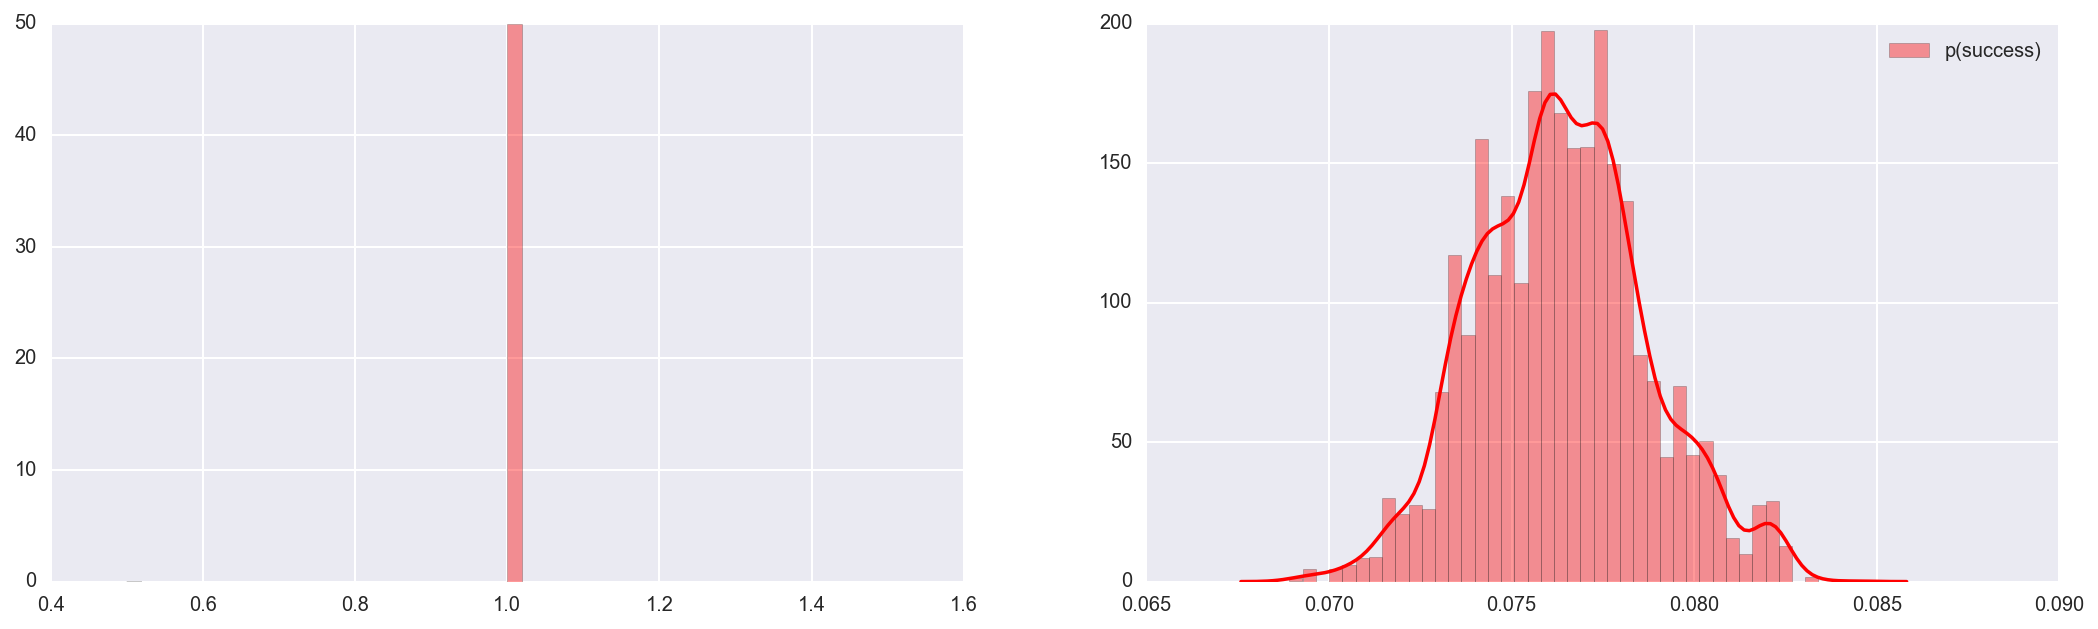

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (18, 5))

successes_t_trace = mcmc_t.trace('successes')[:]
p_success_t_trace = mcmc_t.trace('p_success')[:]

sns.distplot(successes_t_trace, ax = axs[0], label = 'successes', color = 'red')
sns.distplot(p_success_t_trace, ax = axs[1], label = 'p(success)', color = 'red')

plt.legend()

print 'Successes mean probability:', np.mean(p_success_t_trace)
print 'Successes mean count:', np.mean(successes_t_trace)

1.0 0.076393322324


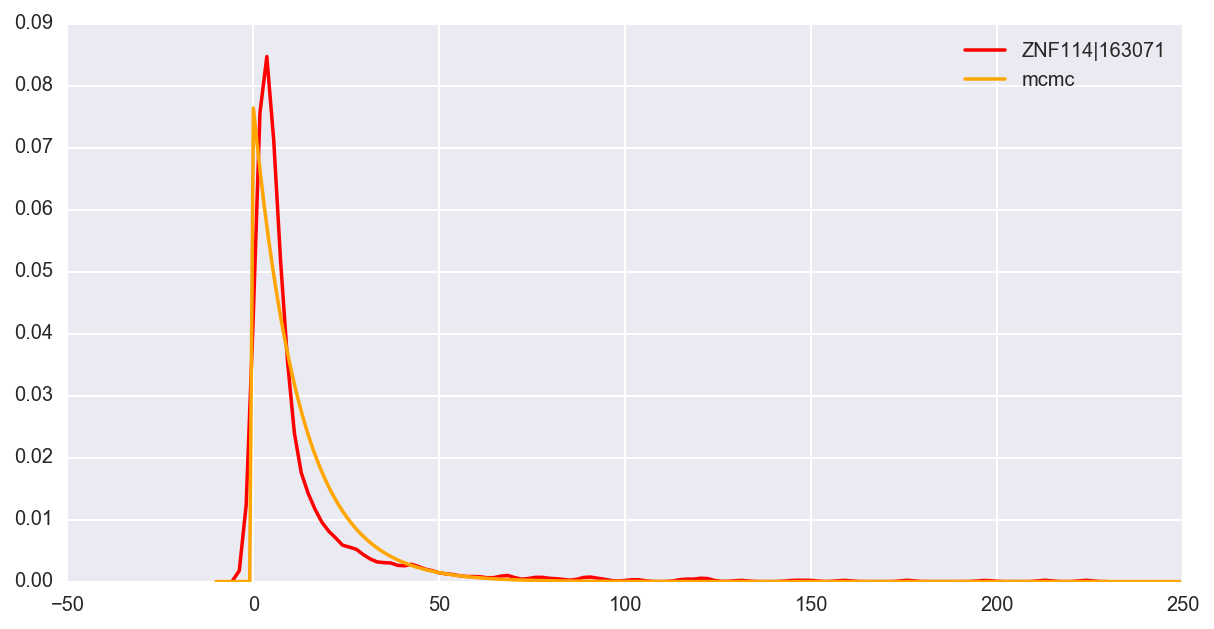

In [17]:
plt.figure(figsize=(10, 5))
sns.kdeplot(tumor[sample_row], shade = False, color = 'red')

n = np.mean(successes_t_trace)
p = np.mean(p_success_t_trace)

print n, p

x = np.arange(-10, 250, 1)
pmf = scipy.stats.nbinom.pmf(x, n, p)
pylab.plot(x, pmf, label = 'mcmc', color = 'orange')
plt.legend()

# Healthy

In [19]:
successes_h = pymc.DiscreteUniform('successes', lower = 1, upper = 20)

p_successes_h = pymc.Uniform('p_success', 0, 1)

@deterministic()
def mu_h(p = p_successes_h, s = successes_h):
    return successes_h / p_successes_h - successes_h

obs_h = pymc.NegativeBinomial('healthy', mu = mu_h, alpha = successes_h, value = healthy[sample_row], observed = True)

In [26]:
model_h = pymc.Model([successes_h, mu_h, obs_h])

map_h = pymc.MAP(model_h)
map_h.fit()

mcmc_h = pymc.MCMC(model_h)
mcmc_h.sample(100000, 5000)

 [-----------------100%-----------------] 100000 of 100000 complete in 117.0 sec

Plotting successes
Plotting p_success


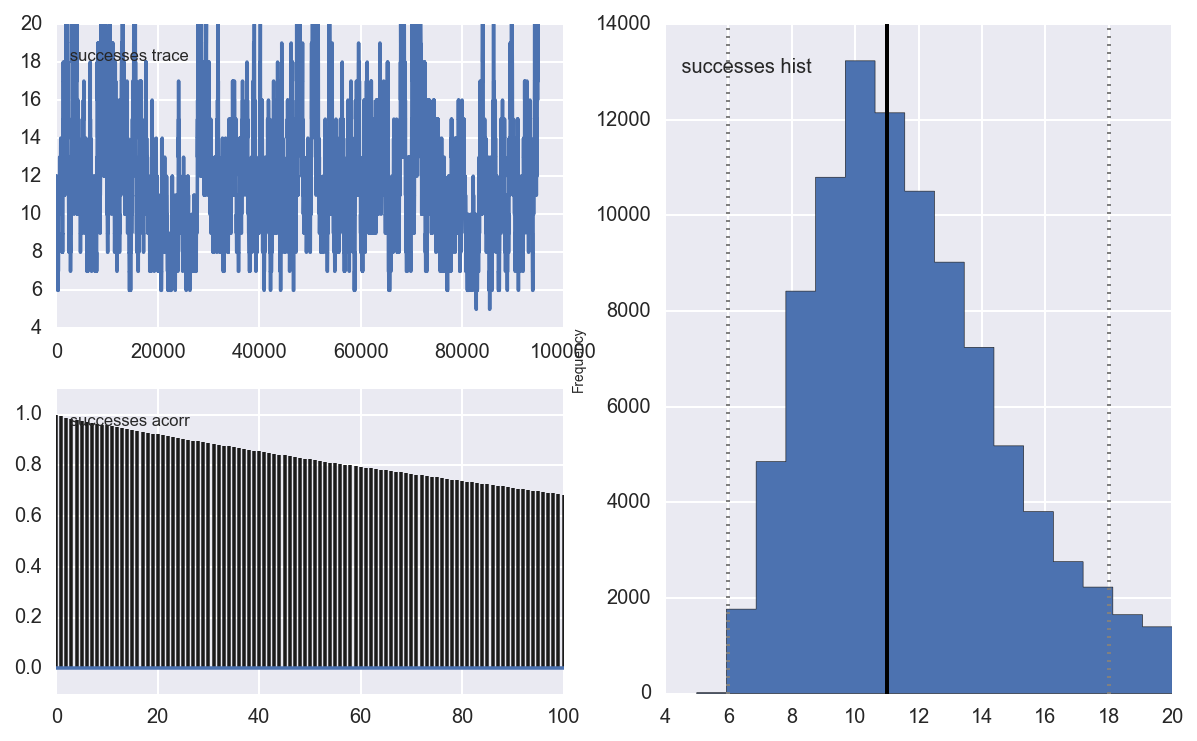

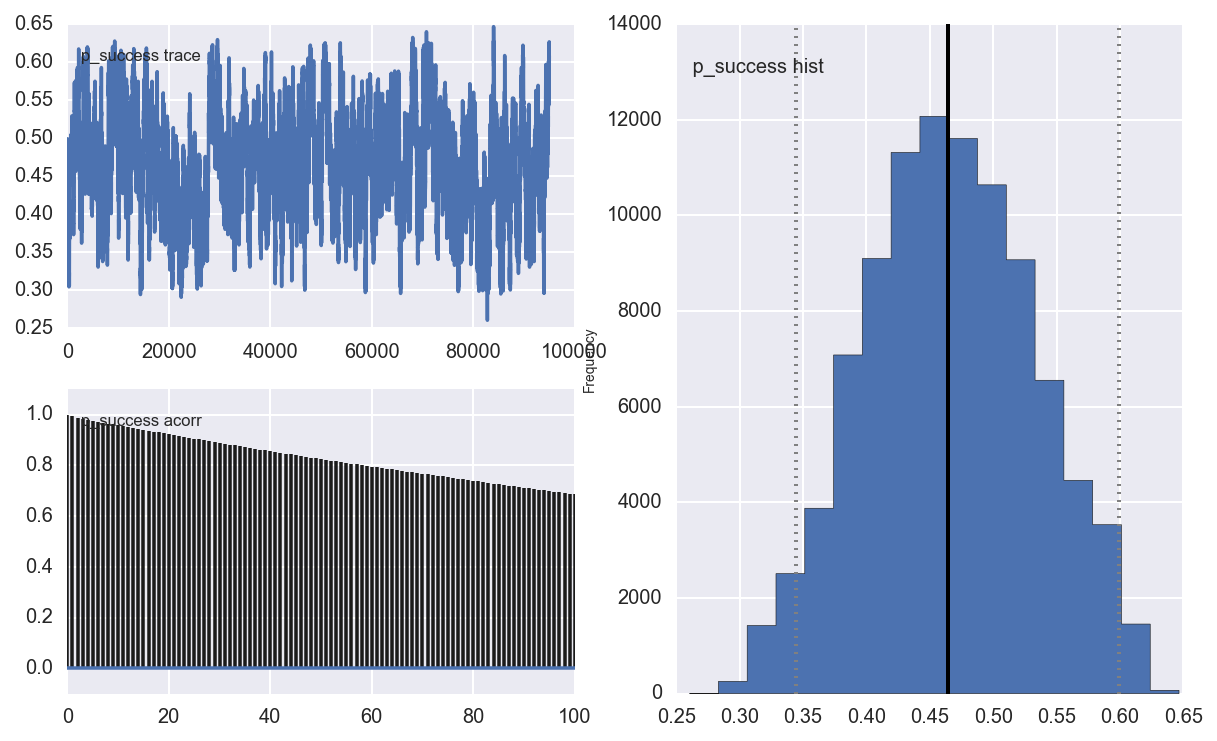

In [27]:
mcplot(mcmc_h.trace('successes'), common_scale=False)
mcplot(mcmc_h.trace('p_success'), common_scale=False)

Successes mean probability: 0.466025545654
Successes mean count: 11.6262526316


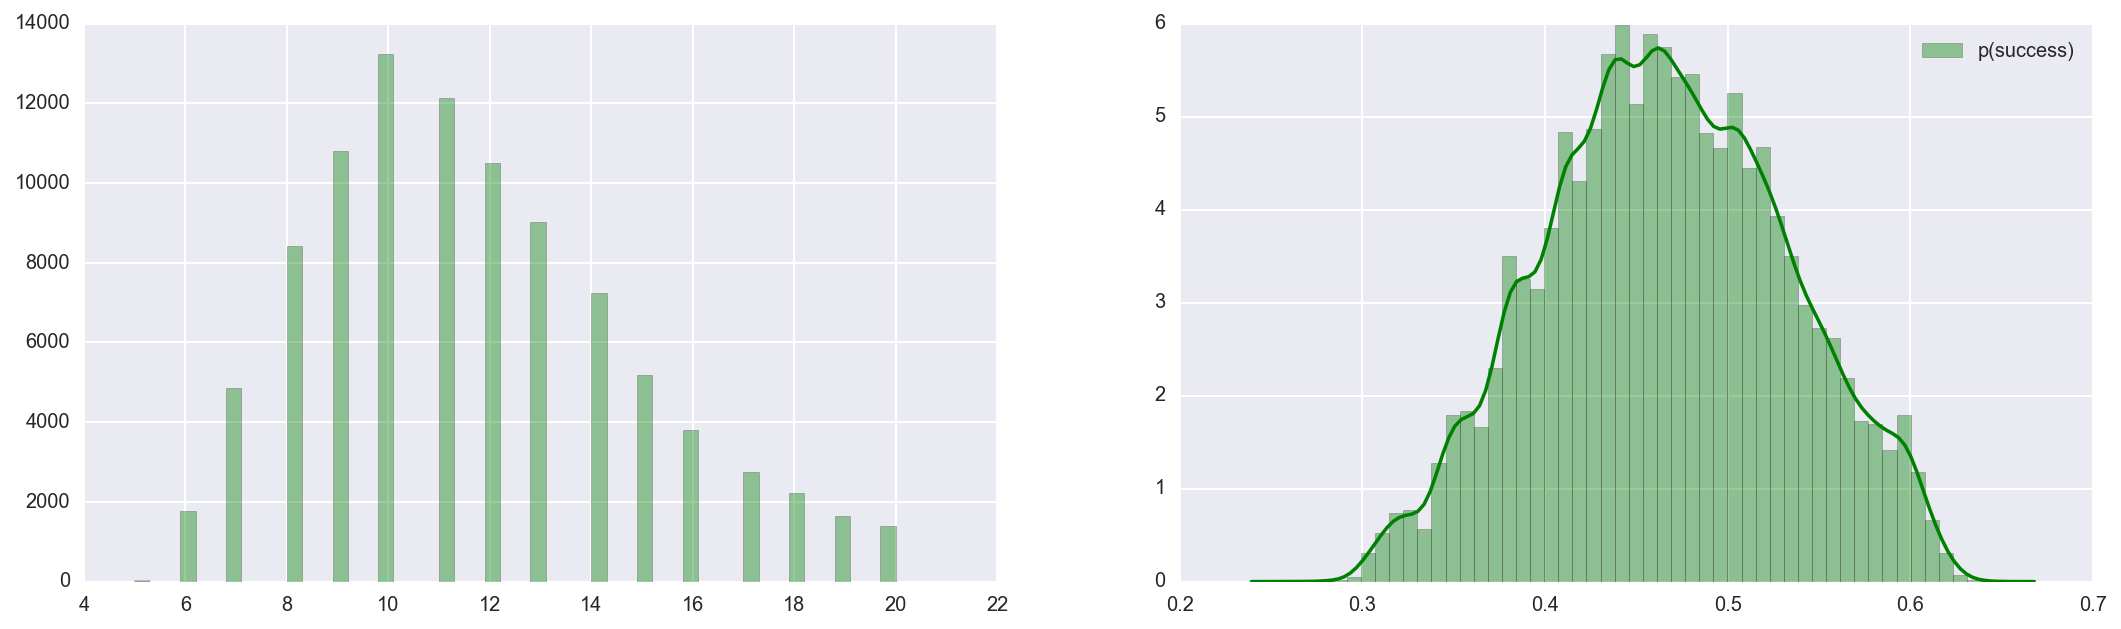

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (18, 5))

successes_h_trace = mcmc_h.trace('successes')[:]
p_success_h_trace = mcmc_h.trace('p_success')[:]

sns.distplot(successes_h_trace, kde = False, ax = axs[0], label = 'successes', color = 'green')
sns.distplot(p_success_h_trace, ax = axs[1], label = 'p(success)', color = 'green')

plt.legend()

print 'Successes mean probability:', np.mean(p_success_h_trace)
print 'Successes mean count:', np.mean(successes_h_trace)

11.6262526316 0.466025545654


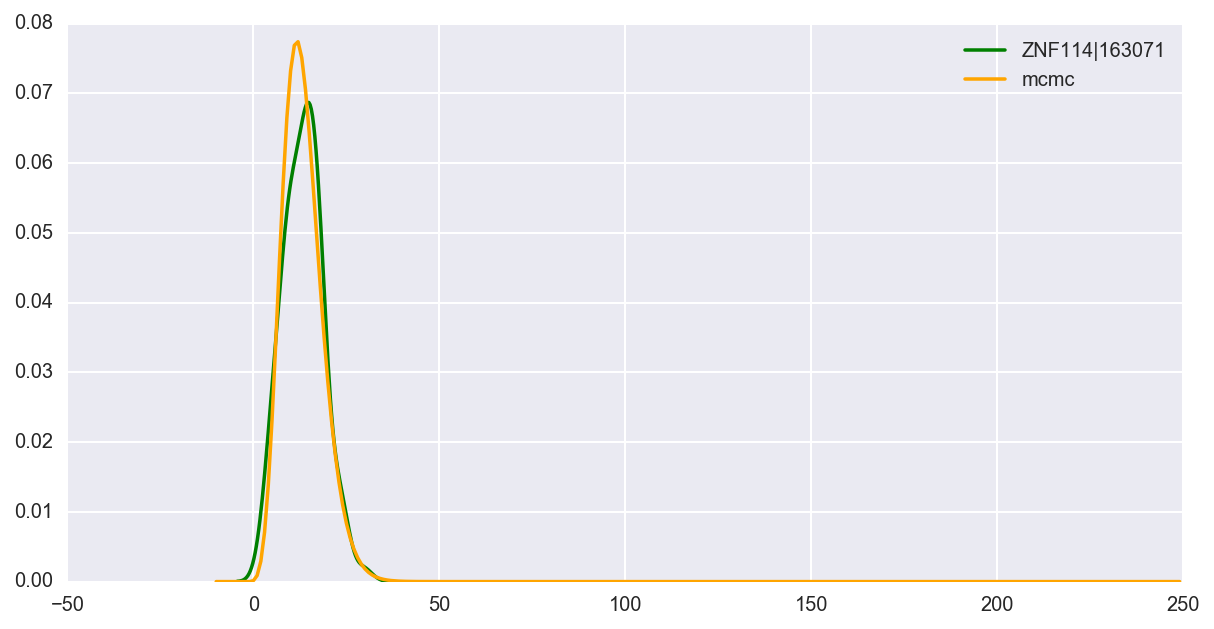

In [30]:
plt.figure(figsize=(10, 5))
sns.kdeplot(healthy[sample_row], shade = False, color = 'green')

n = np.mean(successes_h_trace)
p = np.mean(p_success_h_trace)

print n, p

x = np.arange(-10, 250, 1)
pmf = scipy.stats.nbinom.pmf(x, n, p)
pylab.plot(x, pmf, label = 'mcmc', color = 'orange')
plt.legend()